In [6]:
"""
Example usage of chemrxn-cleaner on ORD data aggregated from a local dataset directory.

Source: https://github.com/open-reaction-database/ord-data/tree/main/data

"""
from __future__ import annotations

from pathlib import Path
from typing import List, Tuple

from rdkit import RDLogger

# Disable all RDKit logs
RDLogger.DisableLog("rdApp.*")

from chemrxn_cleaner import (
    CleaningStats,
    ReactionRecord,
    ElementFilterRule,
    clean_reactions,
    clean_reactions_with_report,
    export_reaction_records_to_json,
    load_reactions,
    max_smiles_length,
    similarity_filter,
    element_filter,
    has_product
)


def load_and_clean_ord_file(path: Path) -> Tuple[List[ReactionRecord], CleaningStats]:
    rxn_ord = load_reactions(
        source=str(path),
        fmt="ord",
    )
    # read ORD (Open Reaction Database) data from your local environment
    TEST = "Cn2cc(c1ccccc1)nn2"
    return clean_reactions_with_report(
        rxn_smiles_list=rxn_ord,
        filters=[
            max_smiles_length(500),
            has_product,
            element_filter(
                allowList=ElementFilterRule(["C", "H", "O", "Cl", "F", "N"], [], []),
                forbidList=ElementFilterRule([], [], []),
            ),
            similarity_filter(query_smiles=TEST, role="any", threshold=0.2),
        ],
    )



rxn_processed, stats = load_and_clean_ord_file('../tests/resources/ord_dataset-sample.pb.gz')

print(f"Reaction cleaning stats: {stats}")

print(f"Total ORD reactions processed after the filter: {len(rxn_processed)}")
export_reaction_records_to_json(records=rxn_processed, path="./export.json")


Reaction cleaning stats: Input: 750, output: 98, failed_parse: 0
Per-filter:
  element_filter: applied=750, passed=295, failed=455
  has_product: applied=750, passed=750, failed=0
  max_smiles_length(500): applied=750, passed=750, failed=0
  similarity_filter: applied=295, passed=98, failed=197
Total ORD reactions processed after the filter: 98


In [3]:
"""
Example usage of chemrxn-cleaner on uspto data aggregated from a local dataset directory.

Source: https://figshare.com/articles/dataset/Chemical_reactions_from_US_patents_1976-Sep2016_/5104873

"""
from __future__ import annotations

from chemrxn_cleaner import (
    ReactionRecord,
    clean_reactions,
    load_reactions,
)

from rdkit import RDLogger

# Disable all RDKit logs
RDLogger.DisableLog("rdApp.*")


USPTO_SOURCE = "../tests/resources/uspto_dataset-sample-small.rsmi"

rxn_list = load_reactions(
    source=USPTO_SOURCE,
    fmt="uspto",
    keep_meta=True,
)
print(f"Loaded {len(rxn_list)} raw reactions from {USPTO_SOURCE}")

rxn_filtered = clean_reactions(rxn_smiles_list=rxn_list)

Loaded 6 raw reactions from ../tests/resources/uspto_dataset-sample-small.rsmi


Parsed 3955 ReactionRecord objects
{'reaction_id': '', 'source': 'json', 'source_ref': None, 'source_file_path': None, 'reaction_smiles': 'Nc1ccc(C)cc1.Clc1ccc(C(F)(F)F)cc1.P(c1ccccc1-c1c(C(C)C)cc(C(C)C)cc1C(C)C)(C1CCCCC1)C1CCCCC1.o1nccc1-c1ccccc1>CN(C)P(N(C)C)(N(C)C)=NP(N(C)C)(N(C)C)=NCC>C1=CC(=CC=C1C(F)(F)F)NC2=CC=C(C=C2)C', 'reactants': ['Nc1ccc(C)cc1', 'Clc1ccc(C(F)(F)F)cc1', 'P(c1ccccc1-c1c(C(C)C)cc(C(C)C)cc1C(C)C)(C1CCCCC1)C1CCCCC1', 'o1nccc1-c1ccccc1'], 'reagents': ['CN(C)P(N(C)C)(N(C)C)=NP(N(C)C)(N(C)C)=NCC'], 'products': ['C1=CC(=CC=C1C(F)(F)F)NC2=CC=C(C=C2)C'], 'atom_mapping': None, 'reaction_class': None, 'procedure': {}, 'temperature_c': None, 'time_hours': None, 'pressure_bar': None, 'ph': None, 'solvents': [], 'catalysts': [], 'bases': ['CN(C)P(N(C)C)(N(C)C)=NP(N(C)C)(N(C)C)=NCC'], 'additives': [], 'atmosphere': None, 'scale_mmol': None, 'yield_value': None, 'yield_type': 'none', 'success': None, 'selectivity': None, 'selectivity_type': None, 'is_balanced': None, 'sanity_

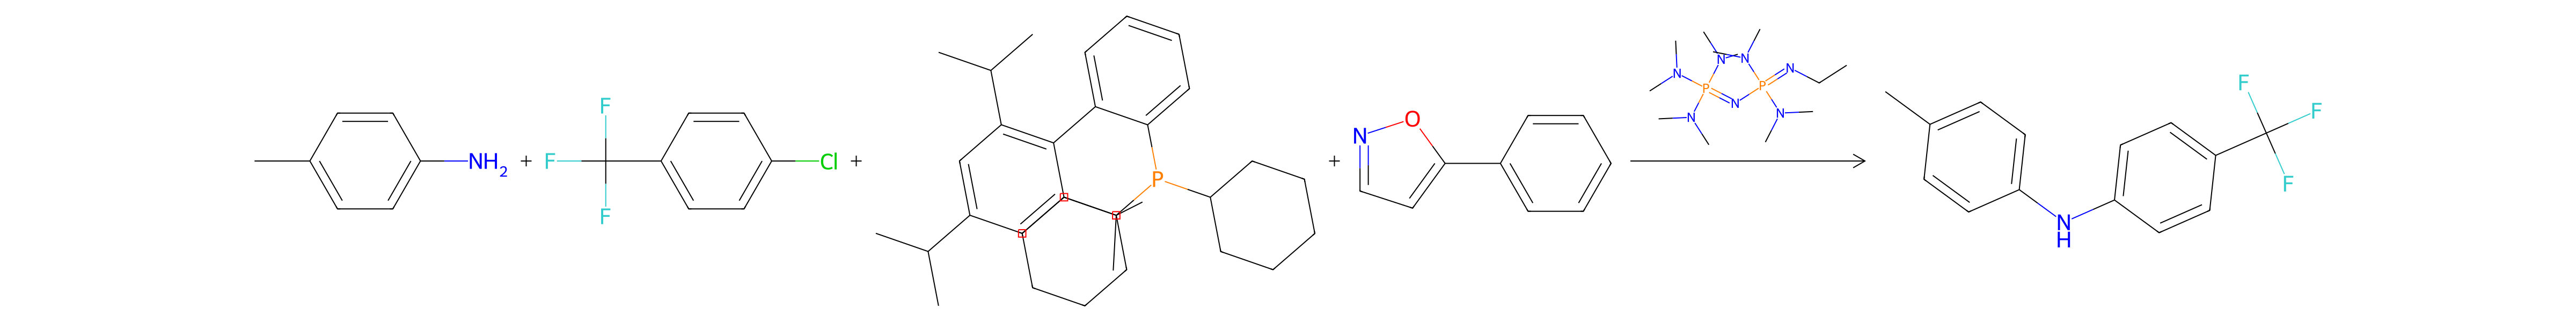

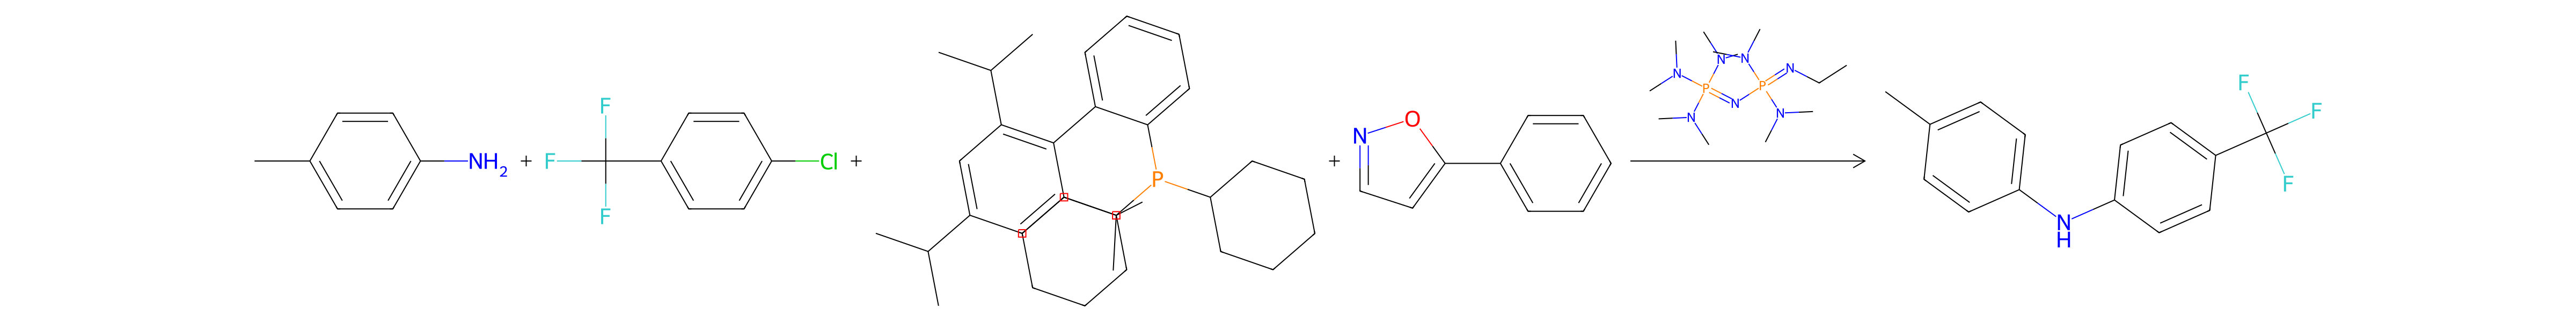

In [4]:
"""
Example usage of chemrxn-cleaner on json data aggregated from a local dataset directory.

Source data: https://github.com/msaebi1993/yield-rxn/tree/master/data/dy/raw

"""
from typing import Any, Dict

from chemrxn_cleaner import load_reactions
from chemrxn_cleaner.parser import parse_reaction_smiles

SOURCE_PATH = "../tests/resources/json_dataset-sample.json"



def to_reaction_record(entry: Dict[str, Any]) -> ReactionRecord:
    """Map raw JSON dicts into ReactionRecord instances."""
    if "reaction_smiles" in entry:
        rec = ReactionRecord.from_dict(entry)
    else:
        reactants = [str(s["smiles"]) for s in entry.get("reactants", [])]
        reagents = [entry["base"]["smiles"]]
        products = [entry["product"]["smiles"]]
        rxn_smiles = ">".join(
            [".".join(reactants), ".".join(reagents), ".".join(products)]
        )
        rec = parse_reaction_smiles(rxn_smiles, strict=False)
        rec.reactants = reactants
        rec.reagents = reagents
        rec.products = products
        rec.bases = reagents
    rec.source = entry.get("source", "json") or "json"
    rec.reaction_id = entry.get("reaction_id", entry.get("id", ""))
    rec.extra_metadata.update(entry.get("meta", {}))
    return rec


rxn_records = load_reactions(source=SOURCE_PATH, fmt="json", mapper=to_reaction_record)
print(f"Parsed {len(rxn_records)} ReactionRecord objects")
print(rxn_records[0].to_dict())
rxn_records[0].show()

Parsed 50258 ReactionRecord objects from uspto stereo
{'reaction_id': '', 'source': 'uspto_stereo', 'source_ref': 'US03930836', 'source_file_path': '../tests/resources/csv_dataset-sample.csv', 'reaction_smiles': '[Br:1][CH2:2][CH2:3][CH2:4][OH:5].[CH3:6][S:7](Cl)(=[O:9])=[O:8].CCOCC>C(N(CC)CC)C>[CH3:6][S:7]([O:5][CH2:4][CH2:3][CH2:2][Br:1])(=[O:9])=[O:8]', 'reactants': ['[Br:1][CH2:2][CH2:3][CH2:4][OH:5]', '[CH3:6][S:7](Cl)(=[O:9])=[O:8]', 'CCOCC'], 'reagents': ['C(N(CC)CC)C'], 'products': ['[CH3:6][S:7]([O:5][CH2:4][CH2:3][CH2:2][Br:1])(=[O:9])=[O:8]'], 'atom_mapping': None, 'reaction_class': None, 'procedure': {}, 'temperature_c': None, 'time_hours': None, 'pressure_bar': None, 'ph': None, 'solvents': [], 'catalysts': [], 'bases': [], 'additives': [], 'atmosphere': None, 'scale_mmol': None, 'yield_value': None, 'yield_type': 'none', 'success': None, 'selectivity': None, 'selectivity_type': None, 'is_balanced': None, 'sanity_check_passed': True, 'warnings': [], 'split': None, 'extra_n

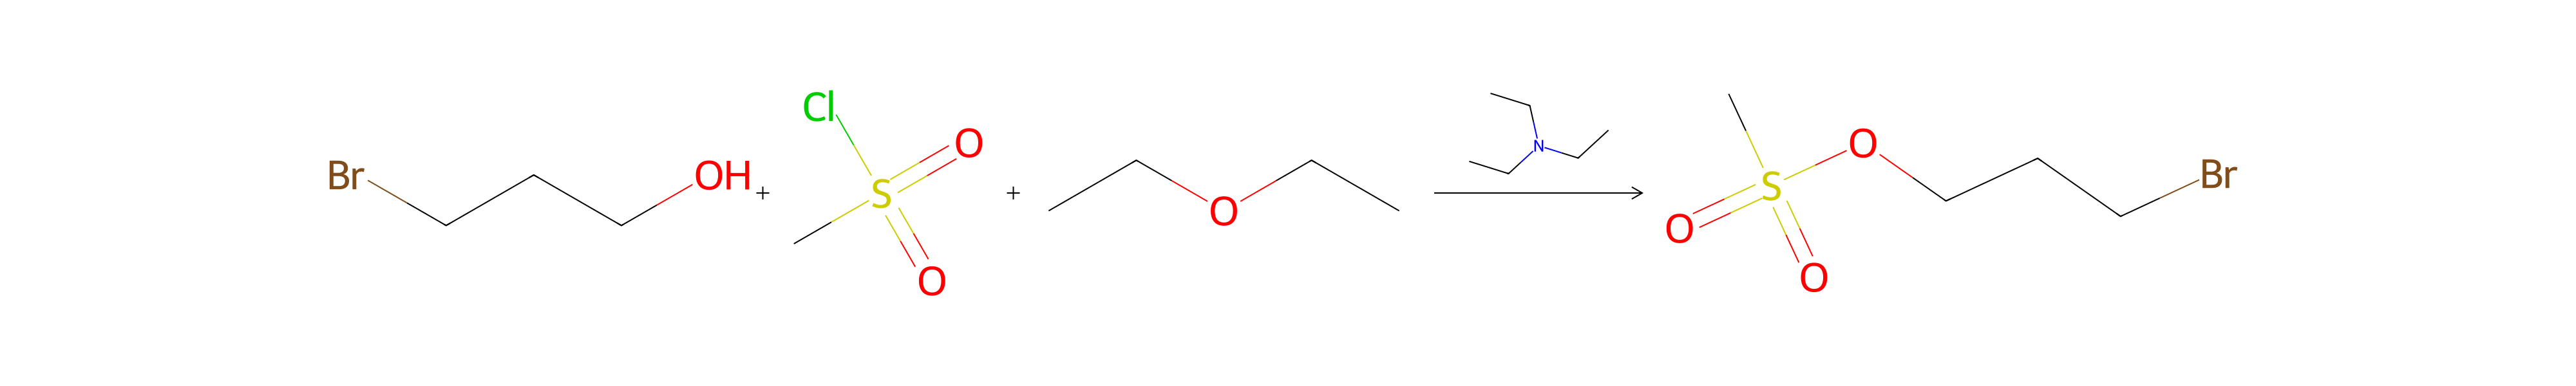

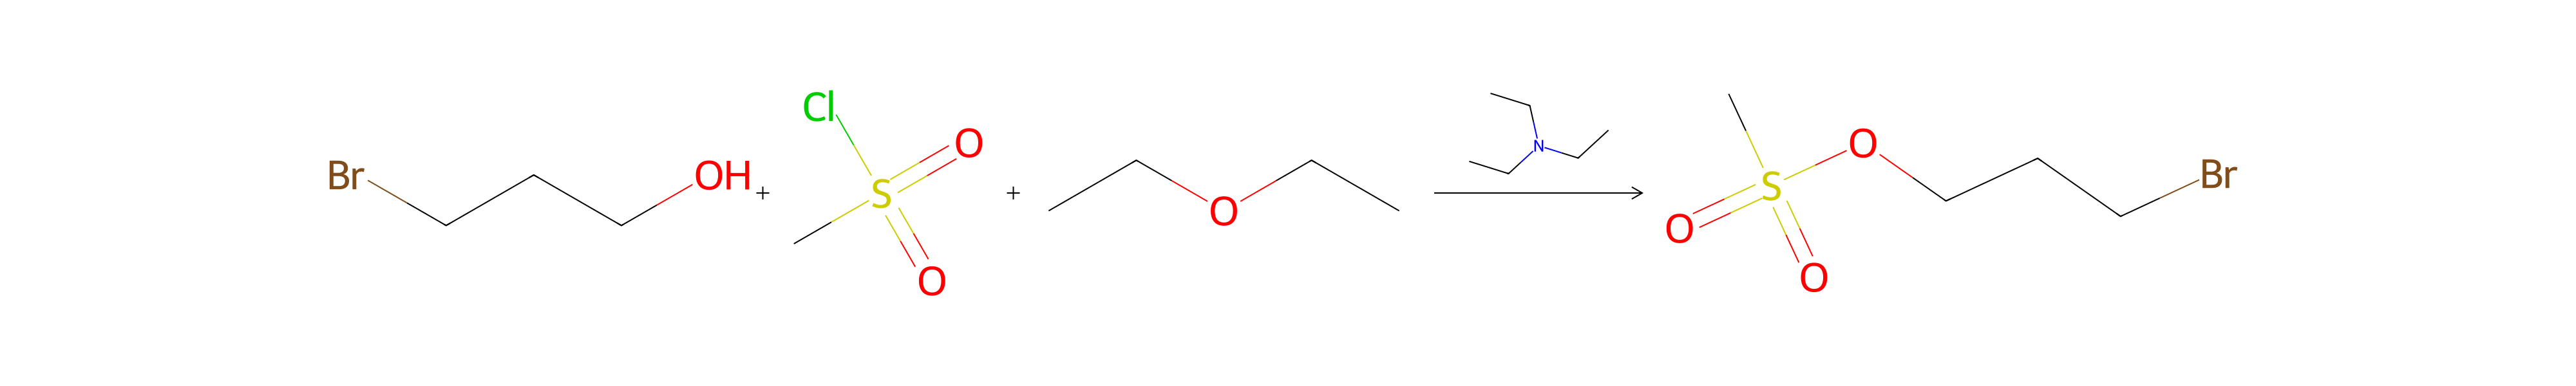

In [5]:
"""
Example usage of chemrxn-cleaner on csv data aggregated from a local dataset directory.

Source data: 

    * https://github.com/truejulosdu13/NiCOlit/blob/master/data/NiCOlit.csv
    * https://ibm.ent.box.com/v/ReactionSeq2SeqDataset (Ref: https://github.com/pschwllr/MolecularTransformer?tab=readme-ov-file)



"""
from typing import Optional

from chemrxn_cleaner import load_reactions

USPTO_STEREO_PATH = "../tests/resources/csv_dataset-sample.csv"


def _to_float(value: Any) -> Optional[float]:
    try:
        text = str(value).replace("%", "").strip()
        if not text:
            return None
        return float(text)
    except Exception:
        return None



def map_row(record: ReactionRecord, row: Dict[str, Any]) -> ReactionRecord:
    record.source = "uspto_stereo"
    record.source_ref = row.get("PatentNumber") or None
    if row.get("CalculatedYield"):
        record.yield_value = _to_float(row.get("CalculatedYield"))
    return record


uspto_stereo = load_reactions(
    source=USPTO_STEREO_PATH,
    fmt="csv",
    reactant_columns=[],
    reagent_columns=[],
    product_columns=[],
    reaction_smiles_column="OriginalReaction",
    delimiter="\t",
    skip_lines=2,
    mapper=map_row,
)
print(f"Parsed {len(uspto_stereo)} ReactionRecord objects from uspto stereo")
print(uspto_stereo[0].to_dict())
uspto_stereo[0].show()